<a href="https://colab.research.google.com/github/Wapiti08/GML/blob/main/graphsage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install stellargraph==1.2.1

     |████████████████████████████████| 435 kB 6.9 MB/s 
     |████████████████████████████████| 462 kB 52.8 MB/s 


In [2]:
from tensorflow import keras
import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import GraphSAGELinkGenerator
# to split the links
from stellargraph.data import EdgeSplitter
from stellargraph.layer import GraphSAGE, link_classification

In [3]:
# load the data inside a graph
data = datasets.Cora()
dataset, _ = data.load(subject_as_feature=True)
data.description

'The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.'

In [8]:
import networkx as nx

# split for the test dataset
edge_splitter_test = EdgeSplitter(dataset)
# return with graph, ids, and labels
# put the keep_connected as true to form a connected reducted graph
graph_test, graph_ids_test, test_labels = edge_splitter_test.train_test_split(p=0.1, seed=42, keep_connected=True)
print(graph_ids_test)
print(len(test_labels))
# split for train dataset
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, graph_ids_train, train_labels = edge_splitter_train.train_test_split(p=0.1, seed=42, keep_connected=True)
print(graph_ids_train)
print(len(train_labels))
print(graph_train.info())

** Sampled 542 positive and 542 negative edges. **
[[1131270  126793]
 [  28278     117]
 [ 206259     117]
 ...
 [ 593544 1130680]
 [1132864  592996]
 [1128531   12169]]
1084
** Sampled 488 positive and 488 negative edges. **
[[ 642827    3191]
 [ 134128 1113614]
 [ 117315  117316]
 ...
 [1129367 1121569]
 [1129106   87363]
 [  84695    6169]]
976
StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4399

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4399]
        Weights: all 1 (default)
        Features: none


In [13]:
# build the GraphSAGE model
## define the size of batch, number of layer
batch_size = 20
epochs = 20
# List of number of neighbor node samples per layer -- two-layer model
number_samples = [20, 10]

# Generate the Graph for train
G_train = GraphSAGELinkGenerator(graph_train, batch_size, number_samples)
# iter the item, the shuffle can improve the training
# flow method to supply the node and target
train_data_flow = G_train.flow(graph_ids_train, train_labels, shuffle=True)

# Generate the Graph for test
G_test = GraphSAGELinkGenerator(graph_test, batch_size, number_samples)
test_data_flow = G_test.flow(graph_ids_test, test_labels, shuffle=True)

In [21]:
# define the model size --- equals to the number of len(num_samples)
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator = G_train, bias=True, dropout=0.3 
)

x_inp, x_out = graphsage.in_out_tensors()

# define link prediction layer
prediction = link_classification(output_dim=1, output_act='relu', edge_embedding_method='ip')(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [23]:
# stack the GraphSAGE and prediction into keras model
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer = keras.optimizers.Adam(lr=0.01),
    loss = keras.losses.binary_crossentropy,
    metrics = ['acc']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# evaluate the model
ini_results_train = model.evaluate(train_data_flow)
ini_results_test = model.evaluate(test_data_flow)

for name, val in zip(model.metrics_names, ini_results_train):
  print("\t{}: {:.4f}".format(name, val))

for name, val in zip(model.metrics_names, ini_results_test):
  print("\t{}: {:.4f}".format(name, val))


55/55 [==============================] - 4s 80ms/step - loss: 0.6724 - acc: 0.6098
	loss: 0.6718
	acc: 0.5820
	loss: 0.6724
	acc: 0.6098


In [26]:
history = model.fit(train_data_flow, epochs=epochs, validation_data = test_data_flow, verbose=2)

Epoch 1/20
49/49 - 27s - loss: 0.6382 - acc: 0.7141 - val_loss: 0.6282 - val_acc: 0.7998 - 27s/epoch - 558ms/step
Epoch 2/20
49/49 - 18s - loss: 0.4150 - acc: 0.8730 - val_loss: 0.5401 - val_acc: 0.8109 - 18s/epoch - 360ms/step
Epoch 3/20
49/49 - 19s - loss: 0.2677 - acc: 0.9303 - val_loss: 0.4924 - val_acc: 0.8017 - 19s/epoch - 381ms/step
Epoch 4/20
49/49 - 15s - loss: 0.2006 - acc: 0.9549 - val_loss: 0.6662 - val_acc: 0.7989 - 15s/epoch - 297ms/step
Epoch 5/20
49/49 - 12s - loss: 0.1622 - acc: 0.9734 - val_loss: 0.7027 - val_acc: 0.8007 - 12s/epoch - 239ms/step
Epoch 6/20
49/49 - 12s - loss: 0.1393 - acc: 0.9836 - val_loss: 0.7157 - val_acc: 0.8044 - 12s/epoch - 238ms/step
Epoch 7/20
49/49 - 12s - loss: 0.1398 - acc: 0.9805 - val_loss: 0.7890 - val_acc: 0.8127 - 12s/epoch - 239ms/step
Epoch 8/20
49/49 - 13s - loss: 0.1126 - acc: 0.9846 - val_loss: 0.7561 - val_acc: 0.7998 - 13s/epoch - 270ms/step
Epoch 9/20
49/49 - 14s - loss: 0.1015 - acc: 0.9898 - val_loss: 0.8610 - val_acc: 0.8035

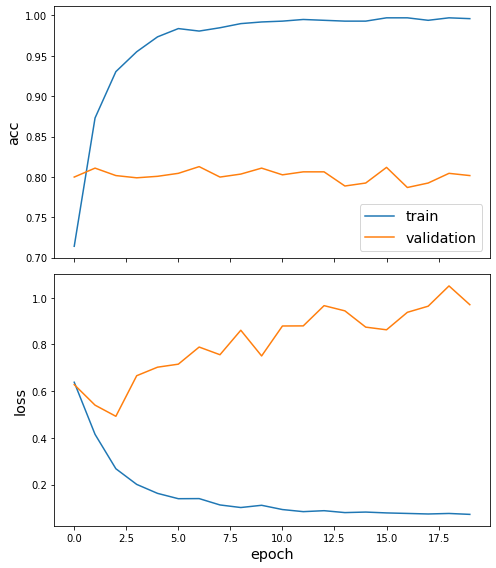

In [27]:
sg.utils.plot_history(history)

In [28]:
# evaludate the fitted model
results_train = model.evaluate(train_data_flow)
results_test = model.evaluate(test_data_flow)

for name, val in zip(model.metrics_names, results_train):
  print("\t{}: {:.4f}".format(name, val))

for name, val in zip(model.metrics_names, results_test):
  print("\t{}: {:.4f}".format(name, val))

55/55 [==============================] - 4s 71ms/step - loss: 0.9371 - acc: 0.8017
	loss: 0.0636
	acc: 0.9969
	loss: 0.9371
	acc: 0.8017


In [33]:
test_data_flow[0]

([array([[[0., 0., 0., ..., 0., 0., 1.]],
  
         [[0., 0., 0., ..., 0., 1., 0.]],
  
         [[0., 0., 0., ..., 0., 1., 0.]],
  
         ...,
  
         [[0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 1., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 1.]]], dtype=float32),
  array([[[0., 0., 0., ..., 1., 0., 0.]],
  
         [[0., 0., 1., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 1.]],
  
         [[0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
  array([[[0., 0., 0., ..., 0., 0., 1.],
          [0., 0., 0., ..., 0., 0., 1.],
          [0., 0., 0., ..., 0., 0., 1.],
          ...,
          [0., 0., 0., ..., 0., 0., 1.],
          [0., 0., 0., ..., 0., 0., 1.],
          [0., 0., 0., ..., 0., 0., 1.]],
  
         [[0., 0., 0., ..., 0., 1., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          

In [31]:
model.predict(test_data_flow)

array([[0.18919586],
       [0.85513264],
       [0.06113681],
       ...,
       [0.88171273],
       [0.26597494],
       [0.8091953 ]], dtype=float32)